# Workflow RSAM & DSAR

**The first step is to calculate the data stream. There are several sub-steps:**
1. After removing the instrument response to the seismic signals, apply a bandpass filter to each 24 hours of data, between 2-4.5, 4-8 and 8-16 Hz (corresponding to the RSAM, MF and HF bands).
2. Compute the absolute values of each signal.
3. Subdivide the signals into 10 minutes intervals. For each interval, compute the average value as the RSAM, MF and HF datapoints assigned to that interval.
4. Removing outliers associated with regional earthquakes is optional. We procced as follow: from (2), subdivide the signals into 10 minutes intervals. 
    1. Calculated the mean and standard deviation (mu and sigma) for each interval. 
    2. Apply z-score normalization in log-space to the interval using mu and sigma. 
    3. Check if any value in the interval exceeds a threshold of 3.2 standard deviations above the mean. 
    4. If yes, exclude data points from a 150s mask starting 15s before the outlier located. 
    5. Calculate the average value in the interval excluding points inside the mask: this the RSAM, MF and HF value for the interval.
**To calculate the DSAR, procced as follow:**
1. Integrate the bandpass filtered MF and HF data with time.
2. Take the absolute value and compute averages on 10-minute intervals.
3. Compute the ratio between integrated MF and HF.
**For computing the DSAR median feature proposed as a precursor in this paper follow:**
1. Every 10 minutes in the DSAR data stream, take a 48 hours window (looking backwards).
2. For each window, compute the median.
3. Construct the feature time series with point every 10 minutes corresponding the medians computed from the 48 hours windows.


In [2]:
import numpy as np
import pandas as pd
import obspy
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=9)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

activity
UTC                         
2004-09-23 09:00:00        s
2004-09-25 19:00:00        q
2004-09-26 00:00:00        c
2004-09-29 00:00:00        q
2004-10-01 19:02:00        a
2004-10-02 19:14:00        a
2004-10-02 19:14:00        t
2004-10-03 09:50:00        t
2004-10-03 11:30:00       et
2004-10-03 17:40:00        a
2004-10-04 16:47:00        a
2004-10-04 19:12:00        a
2004-10-05 00:40:00        a
2004-10-05 16:05:00        a
2004-10-11 00:00:00        l
2005-03-09 00:30:00        a
2005-07-02 00:00:00        r
2006-12-19 00:00:00        a
2008-01-16 00:00:00        a
2008-01-16 00:00:00        q
2008-01-16 00:00:00        t
2008-07-10 00:00:00       ee

In [5]:
def read_taper_stream(year,jday):
    st = obspy.Stream()
    st_d = obspy.Stream()
    try:
        # this stream will be used for RSAM and DSAR calculations
        #st_read = obspy.read('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/{}/EDM.UW.2004.{}'.format(jday,jday))
        st_read = client.get_waveforms(network='UW', station='EDM', channel='*',
                                       year='{}'.format(year), doy='{}'.format(jday))
        st += st_read
        st.detrend('demean')
        st.taper(0.05) # find a good value!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
#         # this stream will be safed for the plot, therefor the stream is downsamplet but not processed
#         st_dec = st_read.copy()
#         st_dec = st_dec.decimate(15)  # downsampling for plot only
#         #st_dec.detrend('demean')
#         st_d += st_dec
#         #st_d.merge()
        
    except:
        print('pass {}'.format(jday))
    return(st)

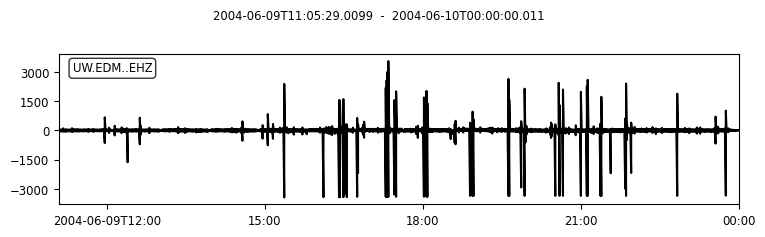

10 Trace(s) in Stream:
UW.EDM..EHZ | 2004-06-09T11:05:29.009900Z - 2004-06-09T11:10:19.999900Z | 100.0 Hz, 29100 samples
UW.EDM..EHZ | 2004-06-09T11:10:20.020900Z - 2004-06-09T12:06:00.010900Z | 100.0 Hz, 334000 samples
UW.EDM..EHZ | 2004-06-09T12:06:00.031000Z - 2004-06-09T13:01:30.021000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:01:30.040900Z - 2004-06-09T13:57:00.030900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T13:57:00.050900Z - 2004-06-09T14:52:30.040900Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T14:52:30.061000Z - 2004-06-09T15:48:00.051000Z | 100.0 Hz, 333000 samples
UW.EDM..EHZ | 2004-06-09T15:48:00.071000Z - 2004-06-09T16:43:10.061000Z | 100.0 Hz, 331000 samples
UW.EDM..EHZ | 2004-06-09T16:43:10.080900Z - 2004-06-09T17:37:30.070900Z | 100.0 Hz, 326000 samples
UW.EDM..EHZ | 2004-06-09T17:37:30.090900Z - 2004-06-09T18:32:20.080900Z | 100.0 Hz, 329000 samples
UW.EDM..EHZ | 2004-06-09T18:32:20.101000Z - 2004-06-10T00:00:00.011000Z | 100.0 Hz, 196

In [6]:
year = 2004
jdays = ['161']#, '160', '161']
st = obspy.Stream()
st_d = obspy.Stream()
for jday in jdays:
    st_read = read_taper_stream(year,jday)
    st += st_read
    #st_d += st_dec
st.plot()
st

In [7]:
def RSAM(data, samp_rate, datas, freq, Nm, N):
    filtered_data = obspy.signal.filter.bandpass(data, freq[0], freq[1], samp_rate)
    filtered_data = abs(filtered_data[:Nm])
    datas.append(filtered_data.reshape(-1,N).mean(axis=-1)*1.e9)
    return(datas)

In [8]:
def DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N):
    # compute dsar
    data = scipy.integrate.cumtrapz(data, dx=1./100, initial=0) # vel to disp
    data -= np.mean(data) # detrend('mean')
    j = freqs_names.index('mf')
    mfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    mfd = abs(mfd[:Nm])
    mfd = mfd.reshape(-1,N).mean(axis=-1)
    j = freqs_names.index('hf')
    hfd = obspy.signal.filter.bandpass(data, freqs[j][0], freqs[j][1], samp_rate)
    hfd = abs(hfd[:Nm])
    hfd = hfd.reshape(-1,N).mean(axis=-1)
    dsar = mfd/hfd
    datas.append(dsar)
    return(datas, dsar)

In [9]:
def nDSAR(datas, dsar):
    ndsar = dsar+np.mean(dsar)/np.std(dsar)
    datas.append(ndsar)
    return(datas)

In [10]:
# creates a df for each trace and append this df to a daily df
def create_df(datas, ti, freqs_names, df):
    datas = np.array(datas)
    time = [(ti+j*600).datetime for j in range(datas.shape[1])]
    df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
    df = pd.concat([df, df_tr])
    return(df)

In [11]:
# main function
def freq_bands_taper(year,jday):   
    ''' 
    calculate and store power in 10 min long time windows for different frequency bands
    sensor measured ground velocity
    freqs: list contains min and max frequency in Hz
    dsar: float represents displacement (integration of)'''
    
    freqs_names = ['rsam','mf','hf', 'dsar', 'ndsar']
    df = pd.DataFrame(columns=freqs_names)
    daysec = 24*3600
    freqs = [[2, 5], [4.5, 8], [8,16]]
    
    st = read_taper_stream(year,jday)

    if len(st)>0: # if stream not empty
        for tr in st:
            datas = []
            data = tr.data
            samp_rate = tr.meta['sampling_rate']
            ti = tr.meta['starttime']
            # round start time to nearest 10 min increment
            tiday = obspy.UTCDateTime("{:d}-{:02d}-{:02d} 00:00:00".format(ti.year, ti.month, ti.day)) # date
            ti = tiday+int(np.round((ti-tiday)/600))*600 # nearest 10 min to starttime
            N = int(600*samp_rate)    # 10 minute windows in seconds
            Nm = int(N*np.floor(len(data)/N)) # np.floor rounds always to the smaller number
            # seconds per day (86400) * sampling rate (100) -> datapoints per day

            for freq, frequ_name in zip(freqs, freqs_names[:3]):
                datas = RSAM(data, samp_rate, datas, freq, Nm, N) # get RSAM for different frequency bands

            datas, dsar = DSAR(data, samp_rate, datas, freqs_names, freqs, Nm, N)
            datas = nDSAR(datas, dsar)
        
            df = create_df(datas, ti, freqs_names, df)
        #print(df)  
        if not os.path.exists('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}'.format(year,st[0].stats['station'])):
            os.makedirs('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}'.format(year,st[0].stats['station']))
        
        df.to_csv('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/{}/{}/nDSAR_taper_{}.csv'.format(year,st[0].stats['station'],jday), index=True, index_label='time')
        
    return()

In [13]:
# calculate frequencie bands
year = 2004
jdays = ['{:03d}'.format(jday) for jday in range(265,270)]
#print(jdays)
for i, jday in enumerate(jdays,1):
    freq_bands_taper(year,jday)
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

1 of 366
2 of 366
3 of 366
4 of 366
5 of 366
6 of 366
7 of 366
8 of 366
9 of 366
10 of 366
11 of 366
12 of 366
13 of 366
14 of 366
15 of 366
16 of 366
17 of 366
18 of 366
19 of 366
20 of 366
21 of 366
22 of 366
23 of 366
24 of 366
25 of 366
26 of 366
27 of 366
28 of 366
29 of 366
30 of 366
31 of 366
32 of 366
33 of 366
34 of 366
35 of 366
36 of 366
37 of 366
38 of 366
39 of 366
40 of 366
41 of 366
42 of 366
43 of 366
44 of 366
45 of 366
46 of 366
47 of 366
48 of 366
49 of 366
50 of 366
51 of 366
52 of 366
53 of 366
54 of 366
55 of 366
56 of 366
57 of 366
58 of 366
59 of 366
60 of 366
61 of 366
62 of 366
63 of 366
64 of 366
65 of 366
66 of 366
67 of 366
68 of 366
69 of 366
70 of 366
71 of 366
72 of 366
73 of 366
74 of 366
75 of 366
76 of 366
77 of 366
78 of 366
79 of 366
80 of 366
81 of 366
82 of 366
83 of 366
84 of 366
85 of 366
86 of 366
87 of 366
88 of 366
89 of 366
90 of 366
91 of 366
92 of 366
93 of 366
94 of 366
95 of 366
96 of 366
97 of 366
98 of 366
99 of 366
100 of 366
101 of 3

In [58]:
# calculate frequencie bands AND save stream
jdays = ['{:03d}'.format(jday) for jday in range(1,366)]
#print(jdays)
st_long = obspy.Stream()
for i, jday in enumerate(jdays,1):
    st_dec = freq_bands_taper(jday)
    st_long += st_dec
    
    sys.stdout.write('\r{} of {}\n'.format(i, len(jdays)))
    sys.stdout.flush()

st_long.write("tmp_2005/st_2005.mseed", format="MSEED") # save stream
st_long

1 of 365
2 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

3 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

4 of 365
5 of 365
6 of 365
7 of 365
8 of 365
9 of 365
10 of 365
11 of 365
12 of 365
13 of 365
14 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


15 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


16 of 365
17 of 365
18 of 365
19 of 365
20 of 365
21 of 365
22 of 365
23 of 365
24 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


25 of 365
26 of 365
27 of 365
28 of 365
29 of 365
30 of 365
31 of 365
32 of 365
33 of 365
34 of 365
35 of 365
36 of 365
37 of 365
38 of 365
39 of 365
40 of 365
41 of 365
42 of 365
43 of 365
44 of 365
45 of 365
46 of 365
47 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

48 of 365
49 of 365
50 of 365
51 of 365
52 of 365
53 of 365
54 of 365
55 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

56 of 365
57 of 365
58 of 365
59 of 365
60 of 365
61 of 365
62 of 365
63 of 365
64 of 365
65 of 365
66 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


67 of 365
68 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


69 of 365
70 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


71 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


72 of 365
73 of 365
74 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


75 of 365
76 of 365
77 of 365
78 of 365
79 of 365
80 of 365
81 of 365
82 of 365
83 of 365
84 of 365
85 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


86 of 365
87 of 365
88 of 365
89 of 365
90 of 365
91 of 365
92 of 365
93 of 365
94 of 365
95 of 365
96 of 365
97 of 365
98 of 365
99 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


100 of 365
101 of 365
102 of 365
103 of 365
104 of 365
105 of 365
106 of 365
107 of 365
108 of 365
109 of 365
110 of 365
111 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


112 of 365
113 of 365
114 of 365
115 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


116 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

117 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

118 of 365
119 of 365
120 of 365
121 of 365
122 of 365
123 of 365
124 of 365
125 of 365
126 of 365
127 of 365
128 of 365
129 of 365
130 of 365
131 of 365
132 of 365
133 of 365
134 of 365
135 of 365
136 of 365
137 of 365
138 of 365
139 of 365
140 of 365
141 of 365
142 of 365
143 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


144 of 365
145 of 365
146 of 365
147 of 365
148 of 365
149 of 365
150 of 365
151 of 365
152 of 365
153 of 365
154 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


155 of 365
156 of 365
157 of 365
158 of 365
159 of 365
160 of 365
161 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


162 of 365
163 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

164 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


165 of 365
166 of 365
167 of 365
168 of 365
169 of 365
170 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

171 of 365
172 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


173 of 365
174 of 365
175 of 365
176 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


177 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


178 of 365
179 of 365
180 of 365
181 of 365
182 of 365
183 of 365
184 of 365
185 of 365
186 of 365
187 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


188 of 365
189 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


190 of 365
191 of 365
192 of 365
193 of 365
194 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


195 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


196 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


197 of 365
198 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


199 of 365
200 of 365
201 of 365
202 of 365
203 of 365
204 of 365
205 of 365
206 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


207 of 365
208 of 365
209 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


210 of 365
211 of 365
212 of 365
213 of 365
214 of 365
215 of 365
216 of 365
217 of 365
218 of 365
219 of 365
220 of 365
221 of 365
222 of 365
223 of 365
224 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


225 of 365
226 of 365
227 of 365
228 of 365
229 of 365
230 of 365
231 of 365
232 of 365
233 of 365
234 of 365
235 of 365
236 of 365
237 of 365
238 of 365
239 of 365
240 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

241 of 365
242 of 365
243 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


244 of 365
245 of 365
246 of 365
247 of 365
248 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


249 of 365
250 of 365
251 of 365
252 of 365
253 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


254 of 365
255 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


256 of 365
257 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


258 of 365
259 of 365
260 of 365
261 of 365
262 of 365
263 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


264 of 365
265 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


266 of 365
267 of 365
268 of 365
269 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

270 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


271 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

272 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

273 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


274 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


275 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

276 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

277 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

278 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

279 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

280 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

281 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

282 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

283 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

284 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

285 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

286 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

287 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

288 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

289 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

290 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

291 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

292 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

293 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

294 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

295 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

296 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

297 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

298 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

299 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

300 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

301 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

302 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

303 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

304 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

305 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

306 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

307 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

308 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


309 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


310 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

311 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

312 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

313 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

314 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


315 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


316 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

317 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

318 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


319 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


320 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

321 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


322 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

323 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


324 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

325 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


326 of 365
327 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

328 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


329 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

330 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


331 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

332 of 365
333 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


334 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

335 of 365
336 of 365
337 of 365
338 of 365
339 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

340 of 365
341 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


342 of 365
343 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

344 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

345 of 365
346 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

347 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

348 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

349 of 365
350 of 365
351 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

352 of 365
353 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

354 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

355 of 365
356 of 365
357 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

358 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


359 of 365
360 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

361 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

362 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))


363 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify 

364 of 365
365 of 365


/tmp/ipykernel_2159282/1807443680.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_tr = pd.DataFrame(zip(*datas), columns=freqs_names, index=pd.Series(time))
/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'tmp/st_2005.mseed'

In [649]:
file_list = sorted(glob.glob('/1-fnp/pnwstore1/p-wd05/PNW2004/UW/2004/*/EDM.UW.2004.*'))

xdays = [file.split('/')[7] for file in file_list] # for these days a seismic record exists
days = ['{:03d}'.format(day) for day in range(159,162)] # I'm interessted in these days
    
jdays = list(set(xdays).intersection(days)) # days in both lists
len(jdays)

2

In [642]:
# to save a masked stream

st_copy = st_long.copy() # copy original stream

for tr in st_copy: # demask stream
    if isinstance(tr.data, np.ma.masked_array):
        tr.data = tr.data.filled(np.nan)

#st_copy.write("tmp/st_2004.mseed", format="MSEED") # save stream copy (demasked)

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


## Read

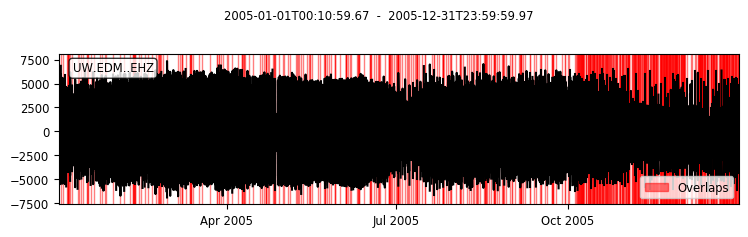

11308 Trace(s) in Stream:

UW.EDM..EHZ | 2005-01-01T00:10:59.670000Z - 2005-01-01T23:59:59.970000Z | 6.7 Hz, 571603 samples
...
(11306 other traces)
...
UW.EDM..EHZ | 2005-12-31T22:29:39.870000Z - 2005-12-31T23:59:59.970000Z | 6.7 Hz, 36135 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [60]:
st_r = obspy.read('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_2005/st_2005.mseed')
st_r.detrend('demean')
#st_r.merge()
st_r.plot()
st_r

In [61]:
st_long = st_r.copy()
st_long.merge()

1 Trace(s) in Stream:
UW.EDM..EHZ | 2005-01-01T00:10:59.670000Z - 2005-12-31T23:59:59.970000Z | 6.7 Hz, 210235603 samples (masked)

In [32]:
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/*_taper_*.csv'))
all_files = all_files[257:289]
all_files

['/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_259.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_260.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_261.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_262.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_263.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_264.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_265.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_266.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_267.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_268.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_269.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/EDM/nDSAR_taper_270.csv',
 '/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004

In [33]:
# all_files = sorted(glob.glob('../data/tmp_2004/EDM/_tmp_taper_*.csv'))
# all_files = all_files[242:275]
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df

rsam            mf            hf      dsar  \
time                                                                      
2004-09-15 00:00:00  5.400351e+08  5.474911e+08  4.872217e+08  1.821518   
2004-09-15 00:10:00  3.151624e+09  2.752944e+09  2.306882e+09  2.271606   
2004-09-15 00:20:00  7.417920e+09  8.014602e+09  6.237525e+09  2.353232   
2004-09-15 00:30:00  8.906337e+09  7.301435e+09  6.117678e+09  2.297871   
2004-09-15 00:40:00  1.745931e+10  1.453499e+10  7.873575e+09  3.485866   
...                           ...           ...           ...       ...   
2004-10-16 23:00:00  8.414046e+11  4.764545e+11  1.657154e+11  4.781170   
2004-10-16 23:10:00  8.312511e+11  4.871962e+11  1.732359e+11  4.703432   
2004-10-16 23:20:00  8.610269e+11  4.779601e+11  1.693699e+11  4.721266   
2004-10-16 23:30:00  6.073267e+11  3.571605e+11  1.224701e+11  4.811835   
2004-10-16 23:40:00  2.855793e+11  1.702005e+11  6.143472e+10  4.661258   

                         ndsar  
time                            
2004-09-15 00:00:00   7.348264  
2004-09-15 00:10:00   7.798352  
2004-09-15 00:20:00   7.879978  
2004-09-15 00:30:00   7.824617  
2004-09-15 00:40:00   9.012612  
...                        ...  
2004-10-16 23:00:00  16.671706  
2004-10-16 23:10:00  16.593969  
2004-10-16 23:20:00  16.611803  
2004-10-16 23:30:00  16.702372  
2004-10-16 23:40:00  16.551795  

[4463 rows x 5 columns]

## Simple Plot

#### Roll and Resample

In [41]:
df_roll = df.rolling('6H', center=True).mean()
df_roll

rsam            mf            hf      dsar  \
time                                                                      
2004-09-15 00:00:00  1.754799e+10  1.609279e+10  1.279855e+10  2.384935   
2004-09-15 00:10:00  1.807115e+10  1.648853e+10  1.305758e+10  2.387233   
2004-09-15 00:20:00  1.927963e+10  1.788654e+10  1.448025e+10  2.364208   
2004-09-15 00:30:00  2.041052e+10  1.970518e+10  1.643639e+10  2.337294   
2004-09-15 00:40:00  2.136694e+10  2.129585e+10  1.811390e+10  2.315196   
...                           ...           ...           ...       ...   
2004-10-16 23:00:00  7.282061e+11  4.012321e+11  1.455902e+11  4.625793   
2004-10-16 23:10:00  7.259026e+11  4.017381e+11  1.459451e+11  4.616408   
2004-10-16 23:20:00  7.261105e+11  4.020198e+11  1.462624e+11  4.607242   
2004-10-16 23:30:00  7.246913e+11  4.033337e+11  1.465265e+11  4.611641   
2004-10-16 23:40:00  7.278205e+11  4.057020e+11  1.472674e+11  4.613923   

                         ndsar  
time                            
2004-09-15 00:00:00   7.911681  
2004-09-15 00:10:00   7.913979  
2004-09-15 00:20:00   7.890954  
2004-09-15 00:30:00   7.864040  
2004-09-15 00:40:00   7.841941  
...                        ...  
2004-10-16 23:00:00  16.516330  
2004-10-16 23:10:00  16.506945  
2004-10-16 23:20:00  16.497779  
2004-10-16 23:30:00  16.502177  
2004-10-16 23:40:00  16.504459  

[4463 rows x 5 columns]

In [34]:
df_res = df.resample('1H').mean()
df_res

rsam            mf            hf      dsar  \
time                                                                      
2004-09-15 00:00:00  8.081577e+09  6.963146e+09  4.871895e+09  2.474653   
2004-09-15 01:00:00  1.775269e+10  1.477698e+10  1.122368e+10  2.510355   
2004-09-15 02:00:00  2.520622e+10  2.406160e+10  2.000081e+10  2.223027   
2004-09-15 03:00:00  3.777922e+10  4.573526e+10  4.240201e+10  1.985098   
2004-09-15 04:00:00  4.436487e+10  5.928382e+10  5.679267e+10  1.833249   
...                           ...           ...           ...       ...   
2004-10-16 19:00:00  7.011660e+11  3.511854e+11  1.324637e+11  4.474162   
2004-10-16 20:00:00  7.167288e+11  3.789127e+11  1.379024e+11  4.661087   
2004-10-16 21:00:00  7.396287e+11  4.002751e+11  1.481965e+11  4.541028   
2004-10-16 22:00:00  7.554892e+11  4.244993e+11  1.541782e+11  4.603993   
2004-10-16 23:00:00  6.853177e+11  3.937944e+11  1.384452e+11  4.735792   

                         ndsar  
time                            
2004-09-15 00:00:00   8.001398  
2004-09-15 01:00:00   8.037101  
2004-09-15 02:00:00   7.749773  
2004-09-15 03:00:00   7.511844  
2004-09-15 04:00:00   7.359995  
...                        ...  
2004-10-16 19:00:00  16.364698  
2004-10-16 20:00:00  16.551624  
2004-10-16 21:00:00  16.431565  
2004-10-16 22:00:00  16.494530  
2004-10-16 23:00:00  16.626329  

[768 rows x 5 columns]

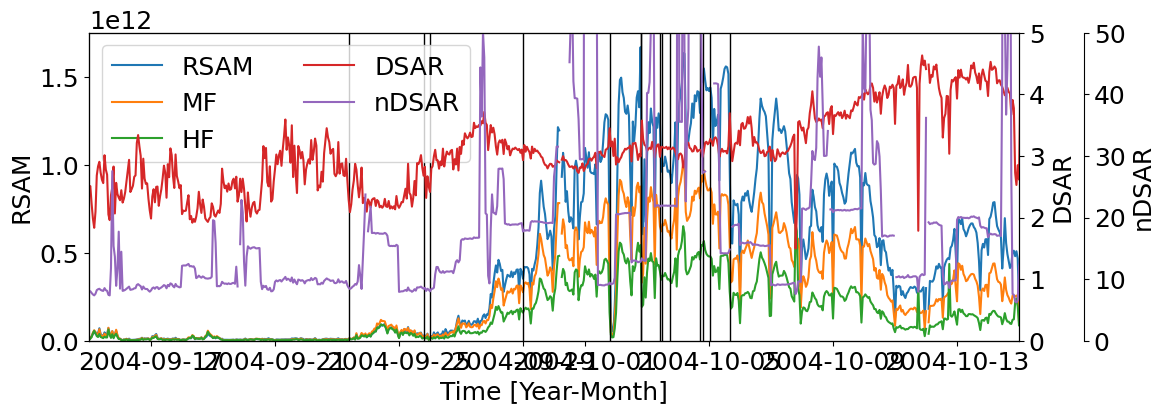

In [48]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(12, 4))

ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
ax.plot(np.nan, label='DSAR')
ax.plot(np.nan, label='nDSAR')

ax2 = ax.twinx()
ax2.plot(df_res['dsar'], label='DSAR', color='C3')
ax3 = ax.twinx()
ax3.plot(df_res['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,1.75e12)
ax.set_ylabel('RSAM')
ax2.set_ylim(0,5)
ax2.set_ylabel('DSAR')
ax3.set_ylim(0,50)
ax3.set_ylabel('nDSAR')
ax3.spines.right.set_position(("axes", 1.07))

#ax.axvline(df_activity.index[0], color='black', linewidth=3, label='Eruption')
for idx in df_activity.index[:14]:
    ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))
#ax.set_ylim(-5e10,1.4e12)
#ax2.set_ylim(1,5.5)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 6))

ax.legend(ncol=2, loc='upper left')
#fig.savefig('../plots/2004_sep_taper_res8.png', bbox_inches='tight', dpi=300)

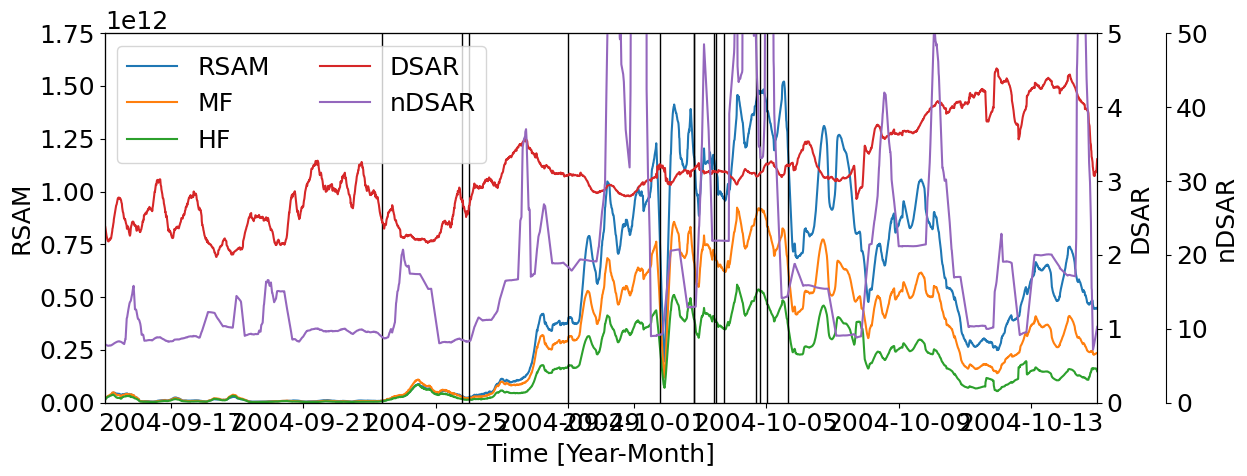

In [49]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_roll['rsam'], label='RSAM')
ax.plot(df_roll['mf'], label='MF')
ax.plot(df_roll['hf'], label='HF')
ax.plot(np.nan, label='DSAR')
ax.plot(np.nan, label='nDSAR')

ax2 = ax.twinx()
ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
ax3 = ax.twinx()
ax3.plot(df_roll['ndsar'], label='nDSAR', color='C4')

ax.set_xlabel('Time [Year-Month]')
ax.set_ylim(0,1.75e12)
ax.set_ylabel('RSAM')
ax2.set_ylim(0,5)
ax2.set_ylabel('DSAR')
ax3.set_ylim(0,50)
ax3.set_ylabel('nDSAR')
ax3.spines.right.set_position(("axes", 1.07))

for idx in df_activity.index[:14]:
    ax.axvline(idx, color='black', linewidth=1)
ax.set_xlim(datetime.datetime(2004,9,15),datetime.datetime(2004,10,15))


ax.legend(ncol=2)
#fig.savefig('../plots/2004_taper_roll1.png', bbox_inches='tight', dpi=300)

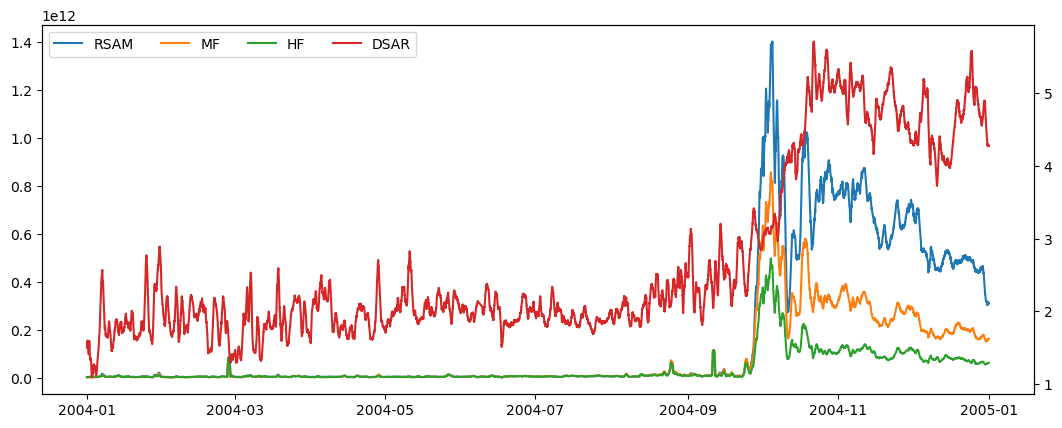

In [70]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_roll['rsam'], label='RSAM')
ax.plot(df_roll['mf'], label='MF')
ax.plot(df_roll['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_roll['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax.legend(ncol=4)

In [126]:
np.arange(start, end, 6)

array([12662., 12668., 12674., 12680., 12686.])

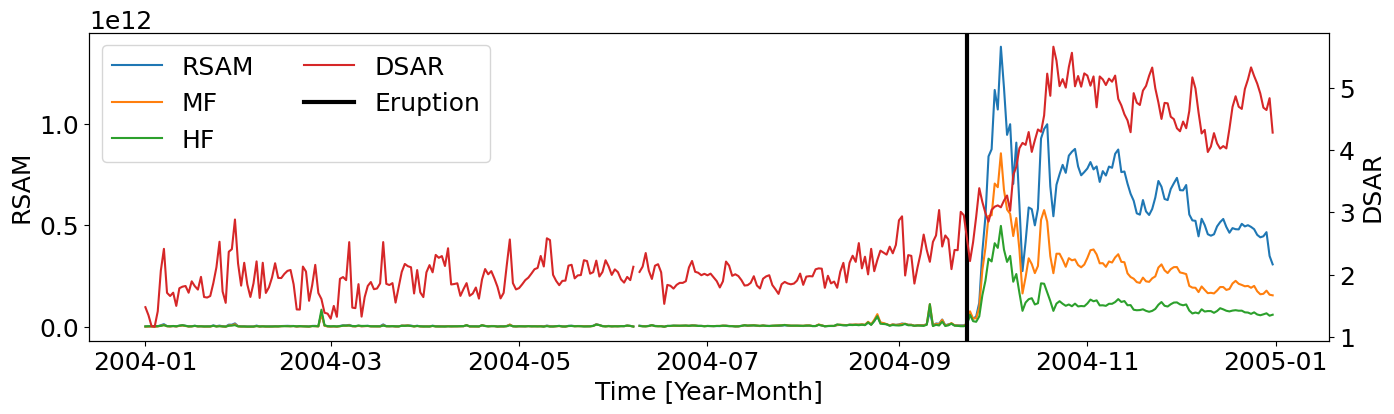

In [159]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1,1, sharex=True, figsize=(16, 4))
# ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
#            label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
ax.plot(df_res['rsam'], label='RSAM')
ax.plot(df_res['mf'], label='MF')
ax.plot(df_res['hf'], label='HF')
ax.plot(np.nan, label='DSAR')

ax2 = ax.twinx()
ax2.plot(df_res['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
plt.xticks(rotation=45)
ax.set_xlabel('Time [Year-Month]')
ax.set_ylabel('RSAM')
ax2.set_ylabel('DSAR')

ax.axvline(datetime.datetime(2004, 9, 23), color='black', linewidth=3, label='Eruption')
ax.legend(ncol=2)
#fig.savefig('../plots/2004_taper_res2.png', bbox_inches='tight', dpi=300)

### Trim

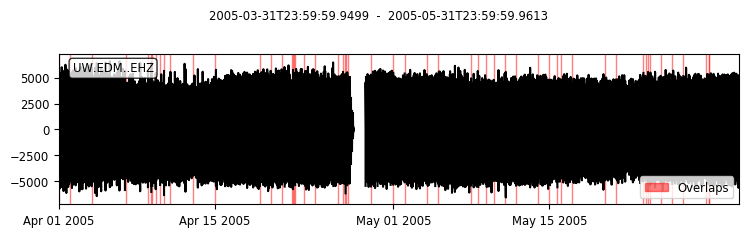

1 Trace(s) in Stream:
UW.EDM..EHZ | 2005-03-31T23:59:59.949900Z - 2005-05-31T23:59:59.949900Z | 6.7 Hz, 35136001 samples (masked)

In [66]:
# trim stream
start_trim = obspy.UTCDateTime(2005,4,1)
end_trim = obspy.UTCDateTime(2005,6,1)
st_trim = st_r.copy()
st_trim.trim(start_trim, end_trim)
st_trim.plot()
st_trim.merge()
st_trim

NameError: name 'st_trim' is not defined

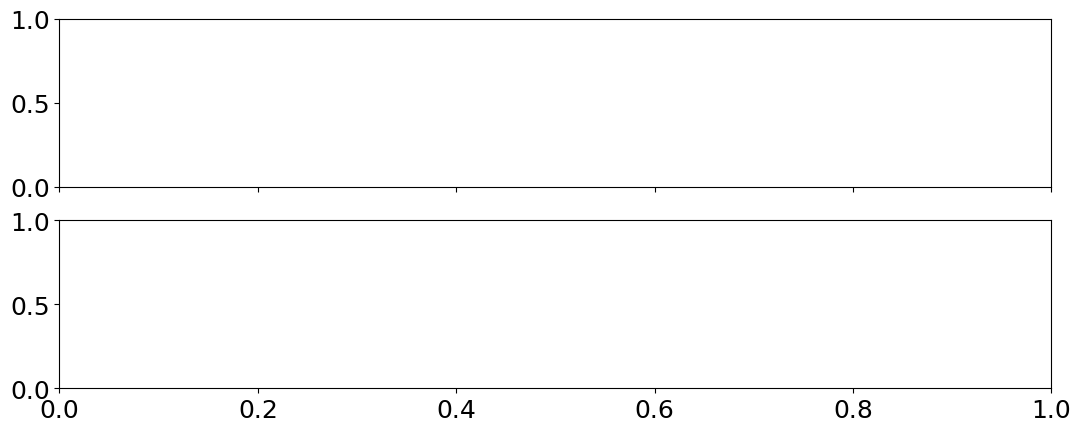

In [93]:
# trim
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_trim[0].times('matplotlib'), st_trim[0].data, color='k', 
           label='{}.{}..{}'.format(st_trim[0].stats['network'],
                                    st_trim[0].stats['station'],
                                    st_trim[0].stats['channel']))
ax[1].plot(df['rsam'], label='LF')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].set_xlim(start_trim.datetime, end_trim.datetime)

ax[1].set_ylabel('RSAM')
ax2.set_ylabel('DSAR')
ax[0].legend(loc='upper left')
ax[1].legend(ncol=4, loc='upper left')

fig.savefig('plots/2005_EDM_2m_1.png', bbox_inches='tight', dpi=300)

### Plot with stream

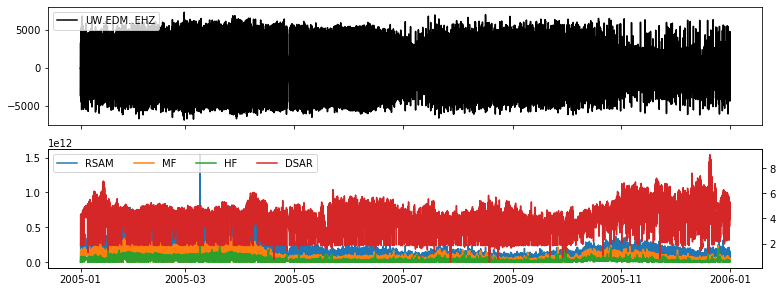

In [65]:
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
    ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k', 
               label='{}.{}..{}'.format(st_long[0].stats['network'],st_long[0].stats['station'],st_long[0].stats['channel']))
    #ax[0].set_ylim(-4000,4000)
    ax[1].plot(df['rsam'], label='RSAM')
    ax[1].plot(df['mf'], label='MF')
    ax[1].plot(df['hf'], label='HF')
    ax[1].plot(np.nan, label='DSAR')

    ax2 = ax[1].twinx()
    ax2.plot(df['dsar'], label='DSAR', color='C3')
    #ax2.set_ylim(0,2.5)

    ax[0].legend(loc='upper left')
    ax[1].legend(ncol=4, loc='upper left')
    fig.savefig('plots/2005_EDM_1y_taper.png', bbox_inches='tight', dpi=300)

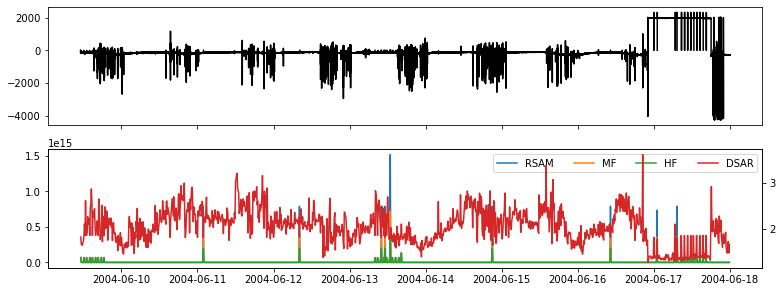

In [424]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))
ax[0].plot(st_long[0].times('matplotlib'), st_long[0].data, color='k')
#ax[0].set_ylim(-4000,4000)
ax[1].plot(df['rsam'], label='RSAM')
ax[1].plot(df['mf'], label='MF')
ax[1].plot(df['hf'], label='HF')
ax[1].plot(np.nan, label='DSAR')

ax2 = ax[1].twinx()
ax2.plot(df['dsar'], label='DSAR', color='C3')
#ax2.set_ylim(0,2.5)
ax[1].legend(ncol=4)

## Multi-year plot

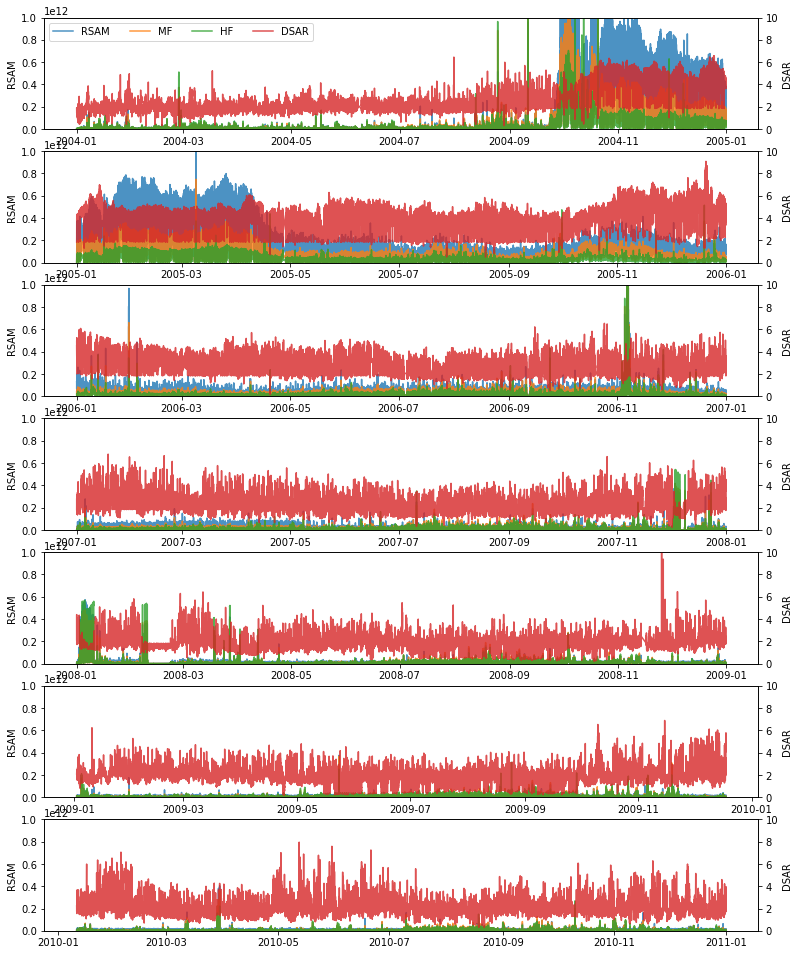

In [106]:
years = range(2004,2011)
sta = 'EDM'
fig, ax = plt.subplots(len(years),1, figsize=(6.4*2, 4.8/2*len(years)))
for i, year in enumerate(years):
    
    # load RSA and DSAR
    all_files = sorted(glob.glob('tmp_{}/{}/_tmp_taper_*.csv'.format(year,sta)))
    #all_files = all_files[1:]
    li = []
    for filename in all_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    
    # plot
    ax[i].plot(df['rsam'], label='RSAM', alpha=0.8)
    ax[i].plot(df['mf'], label='MF', alpha=0.8)
    ax[i].plot(df['hf'], label='HF', alpha=0.8)
    ax[i].plot(np.nan, label='DSAR', alpha=0.8)
    ax[i].set_ylabel('RSAM')
    ax[i].set_ylim(0,1e12)
#     ax[i].set_ylim(1e7,1e13)
#     ax[i].set_yscale('log')

    ax2 = ax[i].twinx()
    ax2.plot(df['dsar'], color='C3', alpha=0.8)
    ax2.set_ylabel('DSAR')
    ax2.set_ylim(0,10)
#     ax2.set_ylim(1e-1,10)
#     ax2.set_yscale('log')

    # plot vertical lines where volcano activityes were recordet
    for index,row in df_activity.iterrows():
        if index.year == year: # plot only one year per subplot
            index=str(index)
            if len(row[0])==1: # plot all start times as solid line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle='-', color='k')
            if len(row[0])>1: # plot all end times as dotted line
                ax[i].axvline(datetime.datetime.strptime(index,"%Y-%m-%d %H:%M:%S"), linestyle=':', color='k')
                
                
ax[0].legend(loc='upper left', ncol=4)
fig.savefig('plots/{}_{}_{}_taper2.png'.format(years[0],years[-1],sta), bbox_inches='tight', dpi=300)

In [ ]:
std_rsam = np.std(df['rsam'])
std_mf = np.std(df['mf'])
std_hf = np.std(df['hf'])
std_dsar = np.std(df['dsar'])

mean_rsam = np.mean(df['rsam'])
mean_mf = np.mean(df['mf'])
mean_hf = np.mean(df['hf'])
mean_dsar = np.mean(df['dsar'])

In [ ]:
df

In [ ]:
# diese df entält nur werte die ALLE im threshold liegen
factor = 10
#df2 = df[ ( df['rsam'] < mean_rsam+factor*std_rsam) & (df['rsam'] > mean_rsam-factor*std_rsam)]
df2 = df[ ( df['rsam'] < 8e9) & (df['rsam'] > 7e9) & #rsam 7.
         ( df['mf'] < 7e9) & (df['mf'] > 6e9) ] #mf 6.
df2

In [ ]:
df_test = df.copy()
idx_rsam = ( df['rsam'] < 8e9) & (df['rsam'] > 7e9)
df_test['rsam'][~idx_rsam] = np.nan
#df_test

In [ ]:
df_roll_mean = df_roll.resample('1H').median()